# Probabilistic linear system identification with Bayesian last layer and BLR with NN features. 

In this notebook, we create the results from Figure 5 and 6 and Table 2 in the paper.

In [97]:
# Choose TRUE or FALSE whether to export figures
export_figures = True
export_dir = '../Plots/SysID/'

from pathlib import Path
Path(export_dir).mkdir(parents=True, exist_ok=True)

In [77]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import importlib
import pdb
import sys
import pickle
import scipy.io as sio
import pandas as pd

# Matplotlib configuration
execfile('../Plots/config_mpl.py')

sys.path.append('../bll/')

import bayesianlastlayer as bll
import tools
import bayli

importlib.reload(bll)
importlib.reload(tools)

<module 'tools' from '/Users/felixfiedler/Documents/git_repos/2022_Paper_BLL_LML/SysID/../bll/tools.py'>

Create results dictionary for Table 2

In [78]:

result_dict = {
    'LML feat': {
        'LML': {
            'alpha_star': {},
            'alpha_max':  {}
        },
        'LPD': {
            'alpha_star': {},
            'alpha_max':  {}
        },
        'MSE': {
            ' ': {},
        },
    }, 
    'MAP feat': {
        'LML': {
            'alpha_star': {},
            'alpha_max':  {}
        },
        'LPD': {
            'alpha_star': {},
            'alpha_max':  {}
        },
        'MSE': {
            ' ': {},
        },
    }, 
    }

##  System description


We investigate a simple LTI system in the form of:
\begin{align}
x_{k+1} &= Ax_k + Bu_k\\
y_k &= Cx_k+Du_k,
\end{align}

with $x \in \mathbb{R}^n$ (states), $u\in \mathbb{R}^m$ (inputs), $y\in \mathbb{R}^p$ (measurements) and system matrices $A \in \mathbb{R}^{n\times n}$, $B \in \mathbb{R}^{n\times m}$, $C \in \mathbb{R}^{p\times n}$ and $D \in \mathbb{R}^{p\times m}$.

The investigated system, displayed below, is a triple-mass-spring system (rotating discs) with two stepper motors ($m=2$) attached to the outermost discs via additional springs. These disc angles are the measured output of the system ($p=3$). The system has a total of $n=8$ states.

To simulate the system, we created a very simple helper class, that keeps the current state and stores the past sequences of inputs, states and outputs.

We import the system class with:

In [79]:
sys.path.append('./LTI_system')
# Import class 'System' from file System.py
import system
importlib.reload(system)

<module 'system' from '/Users/felixfiedler/Documents/git_repos/2022_Paper_BLL_LML/SysID/./LTI_system/system.py'>

Import system matrices, $A,B,C,D$ and create instance of ``System``:

In [80]:
sys_dc = sio.loadmat('./LTI_system/sys_dc.mat')
A = sys_dc['A_dc']
B = sys_dc['B_dc']
C = sys_dc['C']
D = sys_dc['D']

sig_y = np.array([1e-1, 5e-2, 1e-2])
sig_x = 1e-4

dynsys_noise = system.LTISystem(A,B,C,D, sig_y=sig_y, sig_x=sig_x)
dynsys_wo_noise = system.LTISystem(A,B,C,D, sig_y=0, sig_x=0)

## Investigating the System and generate data

Simulate and plot system response.

In [81]:
def get_data(dynsys, sym_steps, l, max_amp=np.pi, cooldown=0., delta_y_out=False):
    dynsys.reset()

    u0 = np.zeros((2,1))

    for k in range(sym_steps,):
        if k<sym_steps*(1-cooldown):
            u0 = system.random_u(u0, switch_prob=0.4, max_amp=max_amp)
        else:
            u0 = np.zeros((2,1))
        dynsys.make_step(u0)

    narx_data = dynsys.narx_io(l=l, delta_y_out=delta_y_out, return_type = 'numpy')

    # Convert to float32
    narx_data = [narx_data[0].astype(np.float32), narx_data[1].astype(np.float32)]
    
    return narx_data

l=3

np.random.seed(42)

delta_y_out = True
narx_data = get_data(dynsys_noise, 1000, l, max_amp=np.pi, cooldown=0.5, delta_y_out=delta_y_out)

Plot results

Text(0.5, 0, 'time')

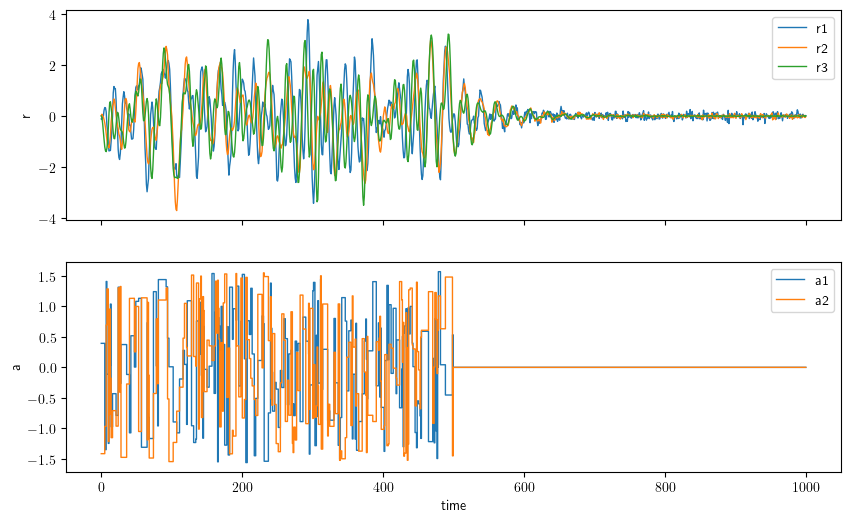

In [82]:
fig, ax = plt.subplots(2,1,figsize=(10,6), sharex = True)
y_lines = ax[0].plot(dynsys_noise.time,dynsys_noise.y)
u_lines = ax[1].step(dynsys_noise.time,dynsys_noise.u)
ax[0].legend(y_lines, ['r1', 'r2', 'r3'])
ax[1].legend(u_lines, ['a1', 'a2'])
ax[0].set_ylabel('r')
ax[1].set_ylabel('a')
ax[1].set_xlabel('time')

Get test data with higher amplitude

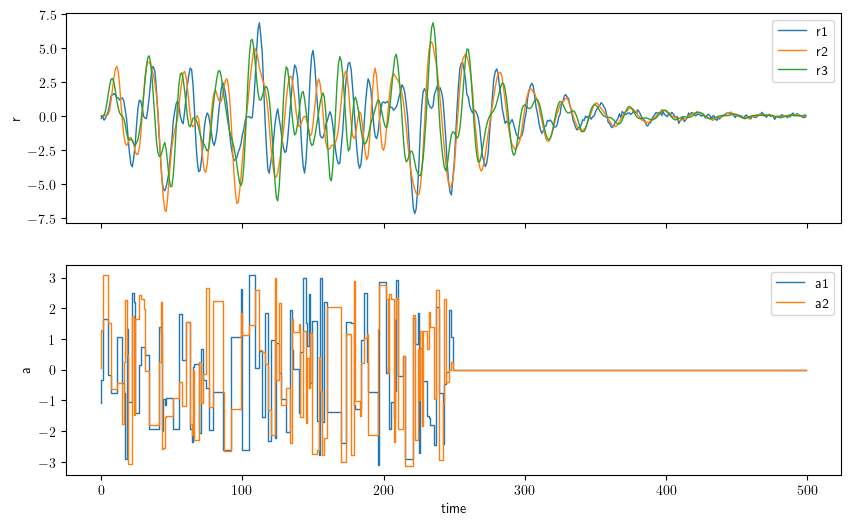

In [83]:
np.random.seed(99)

narx_test = get_data(dynsys_noise, 500, l, max_amp=2*np.pi, cooldown=.5, delta_y_out=delta_y_out)

fig, ax = plt.subplots(2,1,figsize=(10,6), sharex = True)
y_lines = ax[0].plot(dynsys_noise.time,dynsys_noise.y)
u_lines = ax[1].step(dynsys_noise.time,dynsys_noise.u)
ax[0].legend(y_lines, ['r1', 'r2', 'r3'])
ax[1].legend(u_lines, ['a1', 'a2'])
ax[0].set_ylabel('r')
ax[1].set_ylabel('a')
ax[1].set_xlabel('time')


# For testing, only take a subset of this data
_, narx_test  = tools.split(narx_test, test_size = 0.5)

Prepare data for NN training

In [84]:
narx_train, narx_val = tools.split(narx_data, test_size=0.2)

scaler = tools.Scaler(*narx_train)
narx_train_scaled = scaler.scale(*narx_train)
narx_val_scaled = scaler.scale(*narx_val)
narx_test_scaled = scaler.scale(*narx_test)

# Print information about the data
print('Training data with {} samples, {} features and {} outputs.'.format(*narx_train[0].shape, narx_train[1].shape[1]))
print('val data with {} samples, {} features and {} outputs.'.format(*narx_val[0].shape, narx_val[1].shape[1]))

Training data with 797 samples, 15 features and 3 outputs.
val data with 200 samples, 15 features and 3 outputs.


## Keras model with Bayesian last layer

In [85]:
seed = 42    
    
    
def get_narx_model():


    # Fix seeds
    np.random.seed(seed)
    tf.random.set_seed(seed)

    model_input = keras.Input(shape=(narx_train[0].shape[1],))

    # Hidden units
    architecture = [
        (keras.layers.Dense, {'units': 40, 'activation': 'tanh', 'name': '01_dense'}),
        (keras.layers.Dense, {'units': 40, 'activation': 'tanh', 'name': '02_dense'}),
        (keras.layers.Dense, {'name': 'output', 'units': narx_train[1].shape[1]})
    ]

    # Get layers and outputs:
    model_layers, model_outputs = tools.DNN_from_architecture(model_input, architecture)
    joint_model = keras.Model(model_input, [model_outputs[-2], model_outputs[-1]])
    output_model = keras.Model(model_input, model_outputs[-1])

    return joint_model, output_model

## Train model with log-marginal likelihood

In [86]:

# Load model or create and train new model
save_name_bll = 'results/01_LinearSystem_BLL_01.pkl'
load_saved_model = True

if not load_saved_model:
    # Fix seeds
    np.random.seed(seed)
    tf.random.set_seed(seed)

    joint_model_bll, _ = get_narx_model()
    # Get bll model
    bllmodel = bll.BayesianLastLayer(joint_model_bll, scaler)
    #Prepare training
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
    #Setup training:
    bllmodel.setup_training(optimizer)
    # Get callback for early stopping
    cb_early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=1e-4,
    patience=1000,
    verbose=True,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
    )

    #Train
    bllmodel.fit(*narx_train, val=narx_val, epochs=10000, verbose=True, callbacks=[cb_early_stopping])

    bllmodel.save(save_name_bll)
else:
    # Unpickle
    with open(save_name_bll, 'rb') as f:
        bllmodel = pickle.load(f)
        joint_model_bll = bllmodel.joint_model


Print some information about the BLL model

In [87]:
print(bllmodel)

BayesianLastLayer
----------------
State:
- setup_training = False
- prepare_prediction = True
- n_x   = 15
- n_phi = 41
- n_y   = 3
Results:
- train_lml   = [-0.745]
- log_alpha   = [2.849]
- log_sigma_e = [-1.152 -1.312 -2.781]



Store BLL results in result dictionary.

In [88]:
%%capture

result_dict['LML feat']['LML']['alpha_star'].update({
'train': bllmodel.score(*narx_train, scoring='lml'),
'test': bllmodel.score(*narx_test, scoring='lml'),
})
result_dict['LML feat']['LPD']['alpha_star'].update({
'train': bllmodel.score(*narx_train, scoring='lpd'),
'test': bllmodel.score(*narx_test, scoring='lpd'),
})
result_dict['LML feat']['MSE'][' '].update({
'train': bllmodel.score(*narx_train, scoring='mse'),
'test': bllmodel.score(*narx_test, scoring='mse'),
})

Make prediction with BLL model for plotting.

In [89]:
y_pred_test_alpha_opt, y_std_test_alpha_opt = bllmodel.predict(narx_test[0], uncert_type='std', with_noise_variance=True)
y_pred_val_alpha_opt, y_std_val_alpha_opt = bllmodel.predict(narx_val[0], uncert_type='std', with_noise_variance=True)

Search for better alpha values with validation data to enhance the extrapolation performance.

In [90]:
bll_log_alpha_test = bllmodel.grid_search_alpha(*narx_val, scores = ['lml', 'lpd'], rel_range=[-5,20], samples=100, average=True)
bll_log_alpha_train = bllmodel.grid_search_alpha(*narx_train, scores = ['lml', 'lpd'], rel_range=[-5,20], samples=100, average=True)
ind_alpha_max = np.argmax(bll_log_alpha_test['lpd'])
alpha_max_bll = bll_log_alpha_test['log_alpha'][ind_alpha_max]
alpha_opt_bll = bllmodel.log_alpha

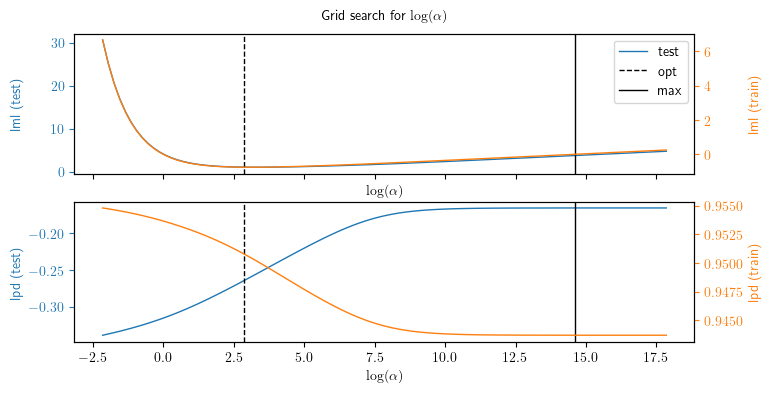

In [91]:
fig, ax = tools.plot_alpha_search(bll_log_alpha_train, bll_log_alpha_test,  alpha_opt_bll, alpha_max_bll, figsize=(8,4), sharex=True)
fig.align_ylabels()

Reset alpha values to the best found value. 

In [92]:
bllmodel.log_alpha = alpha_max_bll

Store KPI with updated alpha values (alpha max).

In [93]:
%%capture
result_dict['LML feat']['LML']['alpha_max'].update({
'train': bllmodel.score(*narx_train, scoring='lml'),
'test': bllmodel.score(*narx_test, scoring='lml'),
})
result_dict['LML feat']['LPD']['alpha_max'].update({
'train': bllmodel.score(*narx_train, scoring='lpd'),
'test': bllmodel.score(*narx_test, scoring='lpd'),
})

In [94]:
# Make prediction
y_pred_train, y_std_train = bllmodel.predict(narx_train[0], uncert_type='std', with_noise_variance=True)
y_pred_val, y_std_val = bllmodel.predict(narx_val[0], uncert_type='std', with_noise_variance=True)
y_pred_test_alpha_max, y_std_test_alpha_max = bllmodel.predict(narx_test[0], uncert_type='std', with_noise_variance=True)

Make parity plot for the predictions with and without updated alpha. Compare true vs. predicted values considering the predicted standard deviation.

In [95]:
narx_test[1].shape

(249, 3)

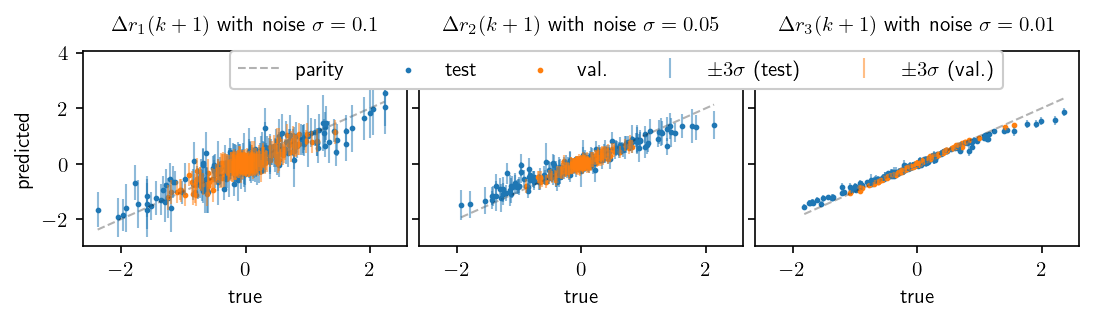

In [98]:
# Parity plot
def parity_plot(y_true_val, y_pred_val, y_std_val, y_true_test, y_pred_test, y_std_test):

    n_outputs = y_true_val.shape[1]

    fig, ax = plt.subplots(1, n_outputs, figsize=(7.15, 2.0), sharey=True, sharex=True, dpi=150)

    y_min_test = np.min(y_true_test, axis=0)
    y_max_test = np.max(y_true_test, axis=0)

    for k in range(n_outputs):
        # Parity line
        y_min_k = y_min_test[k]
        y_max_k = y_max_test[k]
        ax[k].plot([y_min_k, y_max_k],[y_min_k, y_max_k], '--', linewidth=1, color='k', alpha=.3, label='parity')

        # Test data
        ax[k].scatter(y_true_test[:, k], y_pred_test[:, k], s=3, color=color[0], label='test')
        ax[k].errorbar(y_true_test[:, k], y_pred_test[:, k], yerr=3*y_std_test[:, k], 
            fmt='none', ecolor=color[0], alpha=0.5, linestyle='--',
            label=r'$\pm 3\sigma$ (test)')
        
        # Validation data
        ax[k].scatter(y_true_val[:, k], y_pred_val[:, k], s=3, color=color[1], label='val.')
        ax[k].errorbar(y_true_val[:, k], y_pred_val[:, k], yerr=3*y_std_val[:, k], 
            fmt='none', ecolor=color[1], alpha=0.5, linestyle='--',
            label=r'$\pm 3\sigma$ (val.)')

        ax[k].set_xlabel('true')


    ax[0].set_ylabel('predicted')
    ax[0].set_title('$\Delta r_1(k+1)$ with noise $\sigma=0.1$')
    ax[1].set_title('$\Delta r_2(k+1)$ with noise $\sigma=0.05$')
    ax[2].set_title('$\Delta r_3(k+1)$ with noise $\sigma=0.01$')


    fig.tight_layout(pad=.2)
    ax[2].legend(loc=2, ncol=5, bbox_to_anchor=(-1.65, 1.05), framealpha=1)

    return fig, ax

fig, ax = parity_plot(narx_val[1], y_pred_val, y_std_val, narx_test[1], y_pred_test_alpha_max, y_std_test_alpha_max)


if export_figures:
    name = 'LinearSysID_BLL_vs_Linear.pgf'
    fig.savefig(f'{export_dir}{name}')

## MAP with Bayesian linear regression

In [99]:
# Load model or create and train new model
save_name_map = 'results/01_LinearSystem_BLR_01.pkl'
load_saved_model =  True

if not load_saved_model:
    # Get model
    joint_model_map, output_model_map = get_narx_model()

    #Prepare training
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
    output_model_map.compile(optimizer=optimizer, loss='mse', run_eagerly=True)

    # Callback for early stopping
    cb_early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        min_delta=1e-4,
        patience=1000,
        verbose=True,
        mode="auto",
        baseline=None,
        restore_best_weights=True,
    )

    # Fit the output model 
    hist_map_model = output_model_map.fit(*narx_train_scaled, batch_size=1000, validation_data=narx_val_scaled, epochs=10000, verbose=0, callbacks=[cb_early_stopping])

    # Save the joint model
    joint_model_map.save(save_name_map)
else:
    joint_model_map = keras.models.load_model(save_name_map)
    hist_map_model = None

If the model was trained (instead of loaded from disc), display the training progression.

In [100]:

if hist_map_model:
    fig, ax = plt.subplots()

    ax.set_title('Training progression of the MAP model')
    ax.semilogy(hist_map_model.history['loss'], label='train')
    ax.semilogy(hist_map_model.history['val_loss'], label='val')
    ax.set_xlabel('epochs')
    ax.set_ylabel('loss (MSE)')
    ax.legend()


In [101]:
%%capture 

blr_map = bayli.BayesianLinearRegression(scale_x=True, scale_y=True, add_bias=True, estimate_covariance=False)

def feat_fun_map(x):
    phi, y_hat = joint_model_map(x)
    phi = phi.numpy()
    
    return phi

blr_map.set_feature_function(feat_fun_map)


blr_map.fit(*narx_train)


In [102]:
print(blr_map)

BayesianLinearRegression 
--------------------- 
State: 
- scale_x: True 
- scale_y: True 
- add_bias: True 
- trained: True 
- feature_function: True 
- estimate_covariance: False 
- n_x = 15 
- n_phi = 41 
- n_y = 3 
Results: 
- train_lml: 0.025 
- log_alpha: [[1.276]] 
- Sigma_e: [[0.146 0.    0.   ]
 [0.    0.088 0.   ]
 [0.    0.    0.01 ]] 
- log_sigma_e: [-0.961 -1.217 -2.325] 



In [103]:

y_pred_test_map_alpha_opt, y_std_test_map_alpha_opt = blr_map.predict(narx_test[0], return_std = True, with_noise_variance=True)

In [104]:
%%capture

result_dict['MAP feat']['LML']['alpha_star'].update({
'train': blr_map.score(*narx_train, scoring='lml'),
'test': blr_map.score(*narx_test, scoring='lml'),
})
result_dict['MAP feat']['LPD']['alpha_star'].update({
'train': blr_map.score(*narx_train, scoring='lpd'),
'test': blr_map.score(*narx_test, scoring='lpd'),
})
result_dict['MAP feat']['MSE'][' '].update({
'train': blr_map.score(*narx_train, scoring='mse'),
'test': blr_map.score(*narx_test, scoring='mse'),
})

Search for better alpha

In [105]:

blr_log_alpha_test = blr_map.grid_search_alpha(*narx_val, scores = ['lml', 'lpd'], rel_range=[-5,20], samples=100)
blr_log_alpha_train = blr_map.grid_search_alpha(*narx_train, scores = ['lml', 'lpd'], rel_range=[-5,20], samples=100)
ind_alpha_max = np.argmax(blr_log_alpha_test['lpd'])
alpha_max_blr = blr_log_alpha_test['log_alpha'][ind_alpha_max]
alpha_opt_blr = blr_map.log_alpha

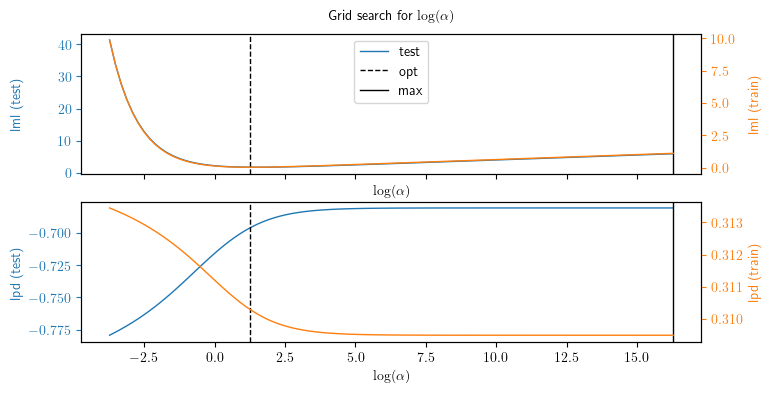

In [106]:
fig, ax = tools.plot_alpha_search(blr_log_alpha_train, blr_log_alpha_test,  alpha_opt_blr, alpha_max_blr, figsize=(8,4), sharex=True)
fig.align_ylabels()

In [107]:
blr_map.log_alpha = alpha_max_blr

In [108]:

%%capture

result_dict['MAP feat']['LML']['alpha_max'].update({
'train': blr_map.score(*narx_train, scoring='lml'),
'test': blr_map.score(*narx_test, scoring='lml'),
})
result_dict['MAP feat']['LPD']['alpha_max'].update({
'train': blr_map.score(*narx_train, scoring='lpd'),
'test': blr_map.score(*narx_test, scoring='lpd'),
})
result_dict['MAP feat']['MSE'][' '].update({
'train': blr_map.score(*narx_train, scoring='mse'),
'test': blr_map.score(*narx_test, scoring='mse'),
})

In [109]:

y_pred_test_map_alpha_max, y_std_test_map_alpha_max = blr_map.predict(narx_test[0], return_std = True, with_noise_variance=True)
y_pred_val_map_alpha_max, y_std_val_map_alpha_max = blr_map.predict(narx_val[0], return_std = True, with_noise_variance=True)


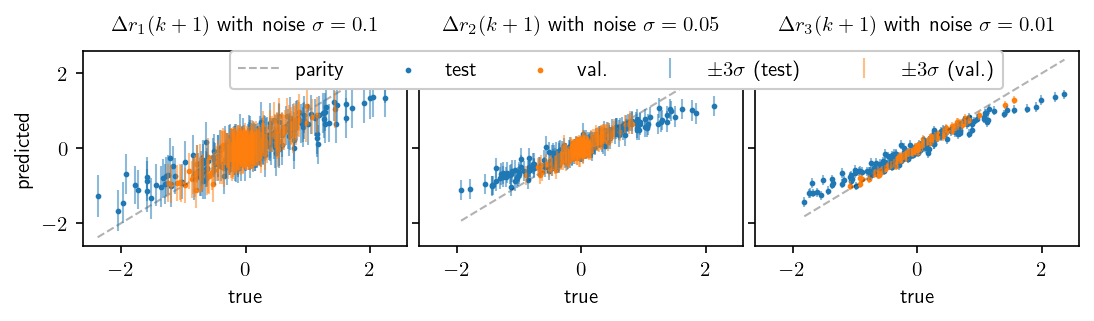

In [111]:

fig, ax = parity_plot(narx_val[1], y_pred_val_map_alpha_max, y_std_val_map_alpha_max, narx_test[1], y_pred_test_map_alpha_max, y_std_test_map_alpha_max)

if export_figures:
    name = 'LLinearSysID_BLR_vs_Linear.pgf'
    fig.savefig(f'{export_dir}{name}')

## Export results to table

In [112]:

def dict2df(d, index_names=['LML feat', 'MAP feat'], max_depth = 2):
    df_list = []
    for key, value in d.items():
        if isinstance(value, dict) and max_depth > 0:
            df_k = dict2df(value, max_depth = max_depth-1)
        else:
            value = {key: np.array([val]).reshape(-1) for key, val in value.items()}
            df_k = pd.DataFrame({key: np.array(val) for key, val in value.items()})
        df_list.append(df_k)

    if list(d.keys()) == index_names:
        df = pd.concat(df_list, axis=0)
        df.index = index_names
    else:
        df = pd.concat(df_list, keys=d.keys(), axis=1)

    return df



df = dict2df(result_dict)
df

LML                                        LPD             \
         alpha_star            alpha_max            alpha_star              
              train       test     train       test      train       test   
LML feat  -0.745242  20.246748  0.006698  22.821548   0.950811 -11.967624   
MAP feat   0.024773  27.250708  1.103594  30.703815   0.310282 -19.789940   

                                    MSE            
         alpha_max                                 
             train       test     train      test  
LML feat  0.943688  -5.613340  0.067950  0.435368  
MAP feat  0.309487 -18.805624  0.079902  0.712840

In [113]:

%%capture
tex_str = df.to_latex(
    float_format='{:0.2f}'.format,
    multicolumn=True,
    multirow=True,
    column_format='p{2.5cm}'+'X'*(len(df.columns)),
)

tex_str = tex_str.replace('tabular', 'tabularx')
tex_str = tex_str.replace('alpha\\_star', r'$\alpha^*$')
tex_str = tex_str.replace('alpha\\_max', r'$\alpha^{\text{max}}$')
tex_str = tex_str.replace('\\begin{tabularx}', '\\begin{tabularx}{\\textwidth}')
tex_str = tex_str.replace('LML feat', r'NN w. BLL')
tex_str = tex_str.replace('MAP feat', r'BLR w. NN features')


tex_str_list = tex_str.split('\n')
tex_str_list[2] = tex_str_list[2].replace('LPD', r'LPD ($\uparrow$ is better)')
tex_str_list[2] = tex_str_list[2].replace('LML', r'NLML ($\downarrow$ is better)')
tex_str_list[2] = tex_str_list[2].replace('MSE', r'MSE ($\downarrow$ is better)')


tex_str_list.insert(4, r'\cmidrule(lr){2-3} \cmidrule(lr){4-5} \cmidrule(lr){6-7} \cmidrule(lr){8-9} ')
tex_str_list.insert(3, r'\cmidrule(lr){2-5} \cmidrule(lr){6-9}\cmidrule(lr){10-11}')

tex_str_list.pop(1) # Remove toprule


tex_str =  '\n'.join(tex_str_list)

if False:
    path = './'

    with open(path.format('SysID_LML_LPD_MSE_comparison.tex'), 'w') as f:
        f.write(tex_str)

    

## Simulation with both models

In [114]:
def bll_narx_func(narx_input):
    out = bllmodel.mean(narx_input.T)[0].T
    
    if delta_y_out:
        y_now = narx_input[(l-1)*3:(l)*3]
        y_next = y_now + out
    else:
        y_next = out

    return y_next

def blr_narx_func(narx_input):
    out = blr_map.predict(narx_input.T, return_std=False).T
    if delta_y_out:
        y_now = narx_input[(l-1)*3:(l)*3]
        y_next = y_now + out
    else:
        y_next = out
    return y_next
    


bll_narx = system.NARX(bll_narx_func, l, y0 = np.zeros((3,1)), u0 = np.zeros((2,1)))
blr_narx = system.NARX(blr_narx_func, l, y0 = np.zeros((3,1)), u0 = np.zeros((2,1)))


In [115]:
np.random.seed(99)

sim_steps = 200
cooldown = 0.7
max_amp = np.pi
u0 = np.zeros((2,1))

bll_narx.reset()
dynsys_wo_noise.reset()
blr_narx.reset()

for k in range(sim_steps):
    if k<l:
        u0 = np.zeros((2,1))
    elif k<sim_steps*(1-cooldown):
        u0 = system.random_u(u0, switch_prob=0.4, max_amp=max_amp)
    else:
        u0 = np.zeros((2,1))
    bll_narx.make_step(u0)
    blr_narx.make_step(u0)
    dynsys_wo_noise.make_step(u0)
    

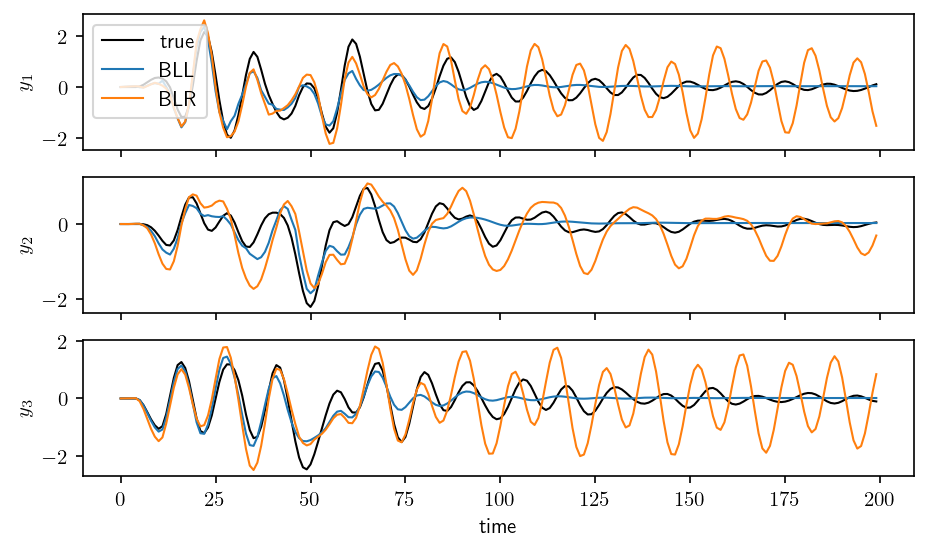

In [116]:
fig, ax = plt.subplots(3, sharex=True, dpi = 150)

for k in range(3):
    ax[k].plot(dynsys_wo_noise.time, dynsys_wo_noise.y[:,k], color='black', label='true')
    ax[k].plot(bll_narx.time, bll_narx.y[:,k], label='BLL')
    ax[k].plot(blr_narx.time, blr_narx.y[:,k], label='BLR')
    ax[k].set_ylabel(f'$y_{k+1}$')

ax[-1].set_xlabel('time')
ax[0].legend()



## Simulation with Noise propagation

In [117]:
def get_A_y(W, delta_y=False):

    y_offset = np.diag(np.ones(2), 1)
    u_offset = np.diag(np.ones(1), 1)

    A_y = np.kron(y_offset, np.eye(3))
    A_u = np.kron(u_offset, np.eye(2))

    A = tools.blkdiag(A_y, A_u)

    W_x = W[:, :-2]

    A[(l-1)*3:l*3,:] =  W_x

    if delta_y:
        A[(l-1)*3:l*3, (l-1)*3:l*3] = np.eye(3)

    return A



In [118]:

def blr_model_eval_w_grad(x):
    x = blr_map.scaler_x.transform(x)
    x = tf.Variable(x)

    with tf.GradientTape() as tape:
        tape.watch(x)
        Phi, y_scaled = joint_model_map(x)
        Phi = tf.concat([Phi, tf.ones((Phi.shape[0], 1))], axis=1)
        # y_scaled = tf.matmul(Phi, blr_map.W)
        y = y_scaled*(blr_map.scaler_y.scale_) + blr_map.scaler_y.mean_
        
    grad = tape.jacobian(y_scaled,x)

    grad = tf.squeeze(grad).numpy()
    dy = y.numpy()

    Sigma_p = np.kron(blr_map.Sigma_e, blr_map.Sigma_p_bar)
    Phi_hat = np.kron(np.eye(blr_map.n_y), Phi)
    cov_y = Phi_hat @ Sigma_p @ Phi_hat.T 

    return dy, cov_y, grad


def bll_model_eval_w_grad(x):
    dy, cov_y, grad = bllmodel.predict(x, uncert_type='cov', return_grad=True, with_noise_variance=True)  
    return dy, cov_y, grad



    

In [119]:
sim_steps = 100
def sim_with_noise_prop(func, sim_steps):
    np.random.seed(42)
    res = {}

    res['Sigma_y_hat'] = l*[tools.blkdiag(0*np.eye(l*3), np.eye((l-1)*2))]
    res['y_std'] = l*[np.sqrt(np.diag(res['Sigma_y_hat'][-1]))]
    res['max_sigma'] = l*[0]


    u0 = np.zeros((2,1))

    dynsys_wo_noise.reset()

    for k in range(l):
        dynsys_wo_noise.make_step(u0)

    res['y'] = dynsys_wo_noise._y[:l]
    res['u'] = dynsys_wo_noise._u[:l]


    for k in range(sim_steps):
        if k<50:
            u0 = system.random_u(u0, switch_prob=0.4, max_amp=np.pi)
        else:
            u0 = np.zeros((2,1))

        narx_in = np.concatenate(res['y'][-l:]+ res['u'][-l:], axis=0).astype(np.float32)
        dy, cov_y, W_NARX = func(narx_in.T)
        y_next = res['y'][-1] + dy.reshape(-1,1)
        A = get_A_y(W_NARX, delta_y=True)
        max_sigma_k = np.max(np.abs(np.linalg.eig(A)[0]))
        res['max_sigma'].append(max_sigma_k)

        Sigma_y_next = A@res['Sigma_y_hat'][-1]@A.T
        Sigma_y_next[(l-1)*3:l*3,(l-1)*3:l*3] += cov_y

        res['Sigma_y_hat'].append(Sigma_y_next)
        res['y_std'].append(np.sqrt(np.diag(res['Sigma_y_hat'][-1])))
        res['u'].append(u0)
        res['y'].append(y_next)

        dynsys_wo_noise.make_step(u0)

    res['max_sigma'] = np.array(res['max_sigma'])
    res['y'] = np.concatenate(res['y'], axis=1).T
    res['u'] = np.concatenate(res['u'], axis=1).T
    res['y_std'] = np.array(res['y_std'])

    return res


res_bll = sim_with_noise_prop(bll_model_eval_w_grad, sim_steps=100)
res_blr = sim_with_noise_prop(blr_model_eval_w_grad, sim_steps=100)

res_blr['y_std'] = np.minimum(res_blr['y_std'], 10)

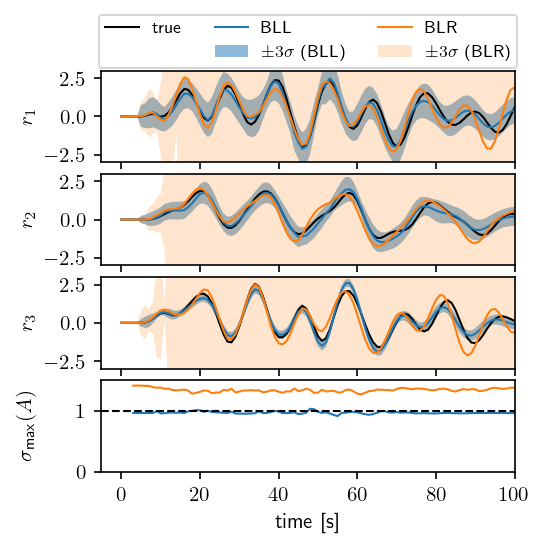

In [120]:
fig, ax = plt.subplots(4, sharex=True, figsize=(3.49, 3.5), dpi=150)

for i in range(3):
    ax[i].plot(dynsys_wo_noise.time, dynsys_wo_noise.y[:,i], color='black', label='true')
    ax[i].plot([],[], color='white', label=' ')

    ax[i].plot(dynsys_wo_noise.time, res_bll['y'][:,i], label='BLL')
    ax[i].fill_between(dynsys_wo_noise.time, res_bll['y'][:,i]-3*res_bll['y_std'][:,i], res_bll['y'][:,i]+3*res_bll['y_std'][:,i], alpha=0.5, label=r'$\pm3\sigma$ (BLL)')
    ax[i].plot(dynsys_wo_noise.time, res_blr['y'][:,i], label='BLR')
    ax[i].fill_between(dynsys_wo_noise.time, res_blr['y'][:,i]-3*res_blr['y_std'][:,i], res_blr['y'][:,i]+3*res_blr['y_std'][:,i], alpha=0.2, label=r'$\pm3\sigma$ (BLR)')
    ax[i].set_ylim(-3,3)
    ax[i].set_ylabel(f'$r_{i+1}$')

ax[3].plot(dynsys_wo_noise.time[l:], res_bll['max_sigma'][l:], label='max singular value of A')
ax[3].plot(dynsys_wo_noise.time[l:], res_blr['max_sigma'][l:], label='max singular value of A')
ax[3].axhline(1, color='k', linestyle='--', linewidth=1)
ax[3].set_ylabel(r'$\sigma_{\text{max}}(A)$')
ax[3].set_ylim(0, 1.5)
ax[3].set_xlim(right=100)



ax[0].legend(loc='upper center', ncol=3, bbox_to_anchor=(.5,1.7), fontsize=8)
ax[-1].set_xlabel('time [s]')
fig.align_ylabels()
fig.tight_layout(pad=0.2)


if export_figures:
    name = 'LinearSysID_Uncert_Propagation.pgf'
    fig.savefig(f'{export_dir}{name}')